<a href="https://colab.research.google.com/github/Shalin-Chakraborty/Encryptix-Internship/blob/main/Encryptix_Task_4_SPAM_SMS_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kaggle preinstallation

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shalinchakraborty","key":"52d2674e436fdec72bb71750f6ca42f1"}'}

In [ ]:
 mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 72.2MB/s]


In [ ]:
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [ ]:
!kaggle datasets download -d andreshg/masksforwordclouds

Dataset URL: https://www.kaggle.com/datasets/andreshg/masksforwordclouds
License(s): GPL-2.0
  0% 0.00/198k [00:00<?, ?B/s]
100% 198k/198k [00:00<00:00, 85.2MB/s]


In [ ]:
!unzip masksforwordclouds.zip

Archive:  masksforwordclouds.zip
  inflating: book-logo-1.jpg         
  inflating: twitter_mask.png        
  inflating: twitter_mask2.png       
  inflating: twitter_mask3.jpg       
  inflating: twitter_mask3.png       
  inflating: twitter_mask4.jpg       
  inflating: wordcloud-man.png       


#Import all the necessary libraries

In [ ]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras.layers.embeddings import Embedding # No longer needed
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score,confusion_matrix
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

#Load data

In [ ]:
df=pd.read_csv('spam.csv',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.shape

(5572, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
df.drop(columns=['Unnamed: 2' , 'Unnamed: 3' , 'Unnamed: 4'], inplace=True)
df.sample(5)

,v1,v2
699,ham,K..u also dont msg or reply to his msg..
3049,ham,Ok
3911,spam,You have an important customer service announc...
4884,ham,Poor girl can't go one day lmao
2095,ham,"Probably, want to pick up more?"


In [ ]:
# RENAME COLUMNS FOR CLARITY
df.rename(columns={'v1':'Label' , 'v2':'Message'} , inplace='True')

# DISPLAY THE FIRST FEW ROWS AFTER RENAMING COLUMNS
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.isnull().sum()

Label      0
Message    0
dtype: int64

In [ ]:
df.describe()

,Label,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
df.groupby('Label').describe()

Message                                                               
        count unique                                                top freq
Label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [ ]:
# convert label to a numerical variable
df['Label_num'] = df.Label.map({'ham':0, 'spam':1})
df.head()

,Label,Message,Label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
df['Message_len'] = df.Message.apply(len)
df.sample(5)

,Label,Message,Label_num,Message_len
2414,ham,O was not into fps then.,0,24
91,ham,Sorry to be a pain. Is it ok if we meet anothe...,0,195
3829,ham,I agree. So i can stop thinkin about ipad. Can...,0,86
655,ham,Tell them the drug dealer's getting impatient,0,45
3758,ham,"GOD ASKED, \What is forgiveness?\"" A little ch...",0,67


Text(0.5, 0, 'Message Length')

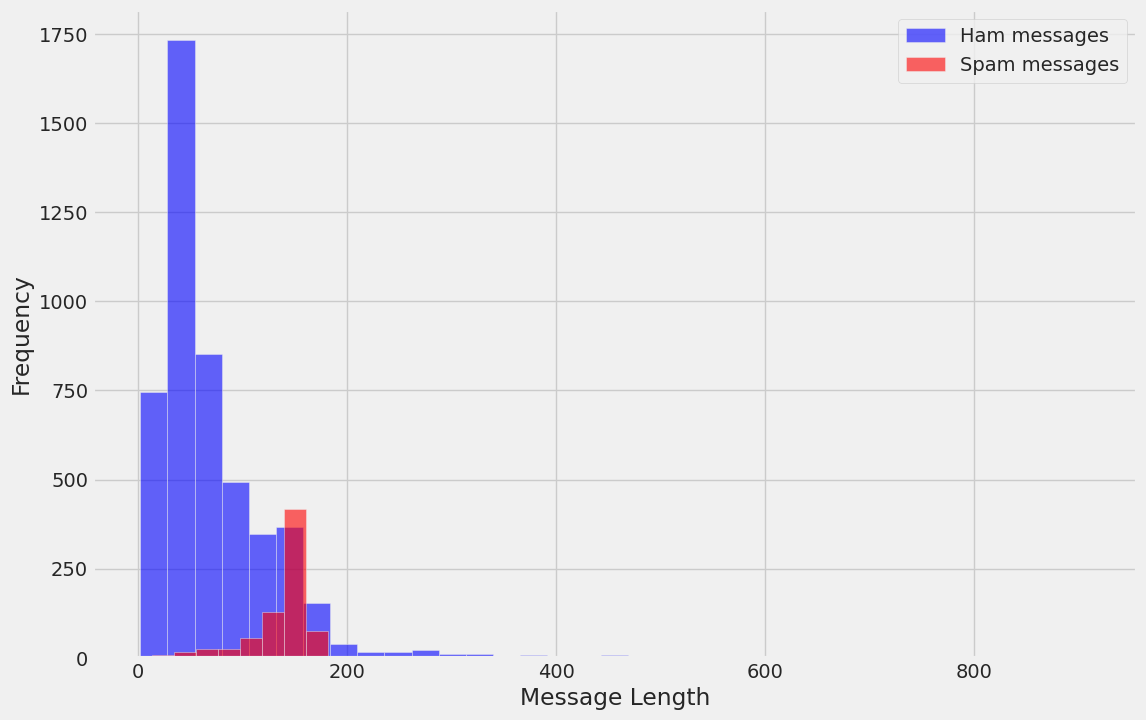

In [ ]:
plt.figure(figsize=(12, 8))

df[df.Label=='ham'].Message_len.plot(bins=35, kind='hist', color='blue', label='Ham messages', alpha=0.6)
df[df.Label=='spam'].Message_len.plot(kind='hist', color='red', label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

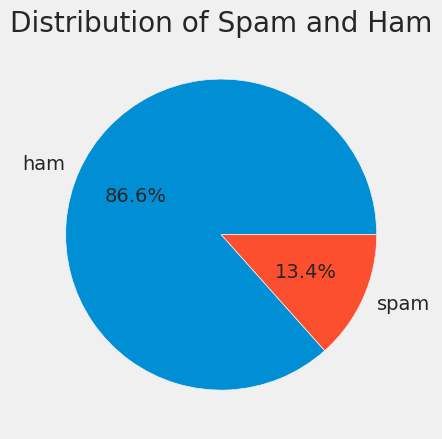

In [ ]:
plt.pie(df['Label'].value_counts(), labels=['ham', 'spam'], autopct='%1.1f%%')
plt.title('Distribution of Spam and Ham')
plt.show()

#Data preprocessing

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

In [ ]:
stemmer = nltk.SnowballStemmer("english")

In [ ]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))

    return text

In [ ]:
df['Message_clean'] = df['Message'].apply(preprocess_data)
df.head()

,Label,Message,Label_num,Message_len,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,0,29,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,nah dont think goe usf live around though


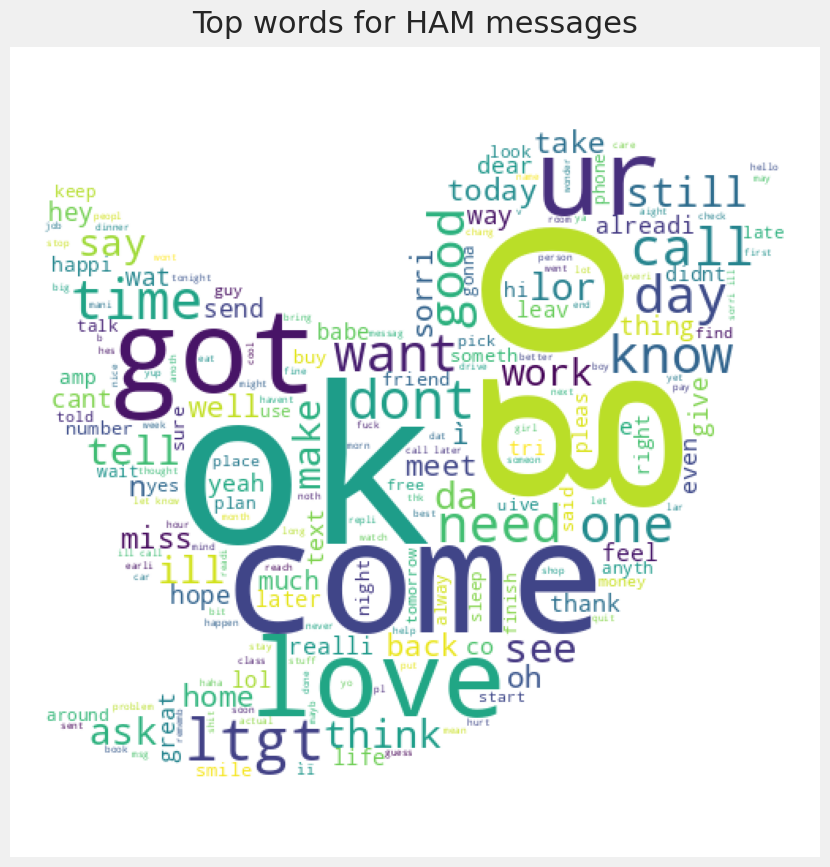

In [ ]:
twitter_mask = np.array(Image.open("twitter_mask3.jpg"))

wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['Label'] == 'ham', 'Message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages', fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

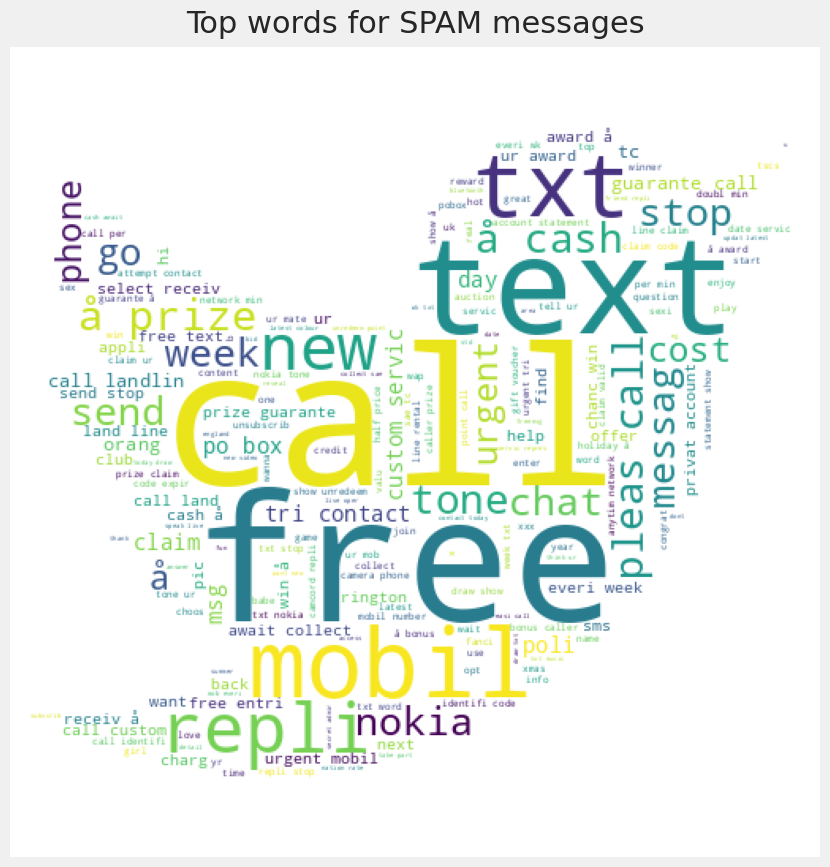

In [ ]:
twitter_mask = np.array(Image.open("twitter_mask3.jpg"))

wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['Label'] == 'spam', 'Message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for SPAM messages', fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
df.head()

,Label,Message,Label_num,Message_len,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,0,29,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,nah dont think goe usf live around though


In [ ]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = df['Message_clean']
y = df['Label_num']

print(len(x), len(y))

5572 5572


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [ ]:
# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [ ]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [ ]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<4179x5717 sparse matrix of type '<class 'numpy.float64'>'
	with 32431 stored elements in Compressed Sparse Row format>

#Model

In [ ]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [ ]:
# Make class anf probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

0.9784637473079684


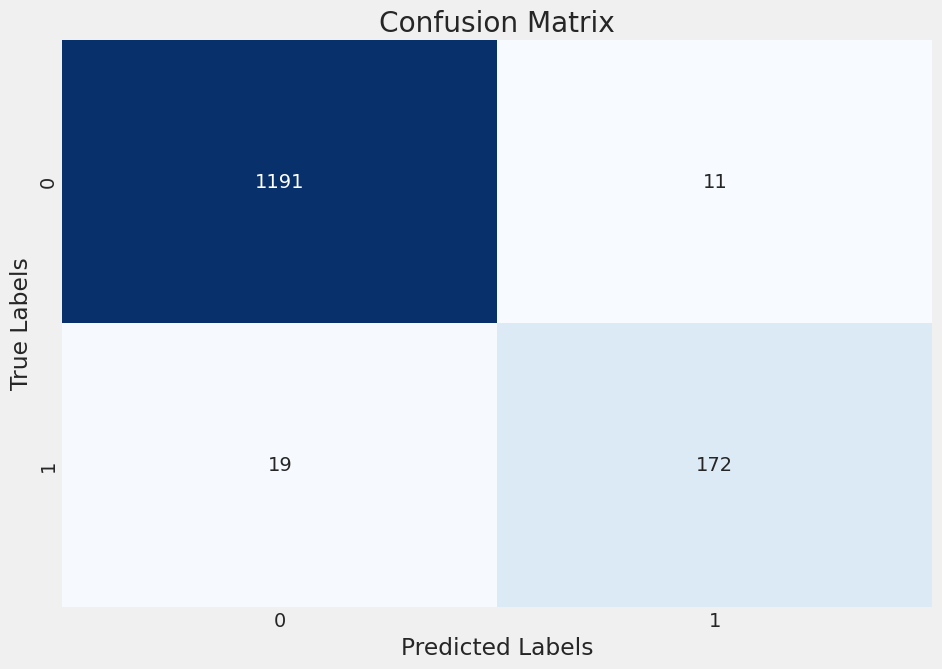

In [ ]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix=metrics.confusion_matrix(y_test, y_pred_class)
# Display confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9745842444094048

###Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()),
                 ('tfid', TfidfTransformer()),
                 ('model', MultinomialNB())])

0.9597989949748744


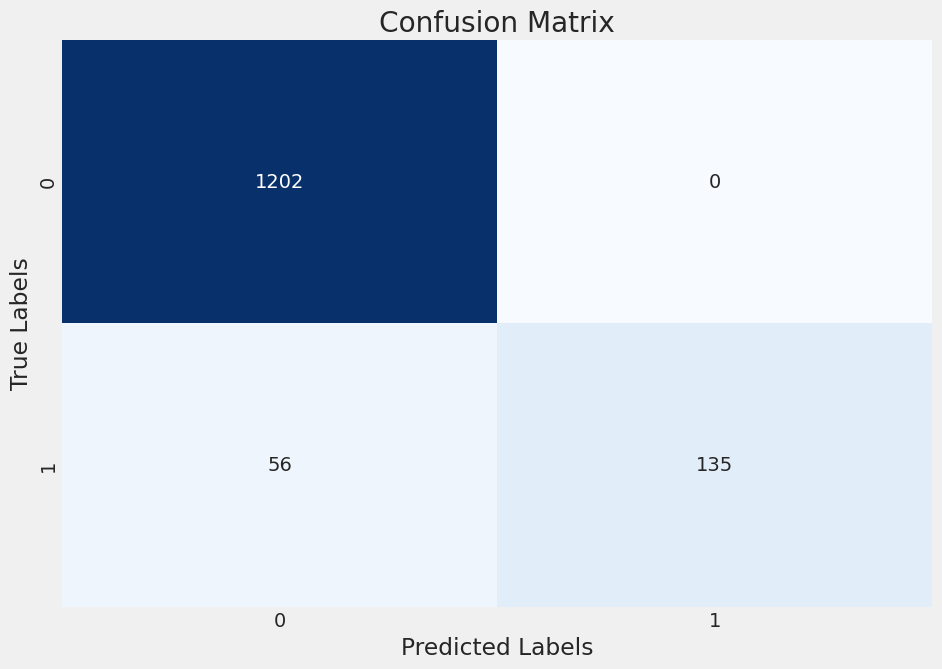

In [ ]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix=metrics.confusion_matrix(y_test, y_pred_class)
# Display confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()